## Keras  CIFAR-10 MobileNet Save Model Example

MobileNet model exported for prediction on device with tensor/io. Exported using the keras `model.save` api.

Based on https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub and https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import PIL.Image as Image
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
def enable_memory_growth():
    physical_devices = tf.config.experimental.list_physical_devices('GPU') 
    try: 
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        # tf.config.gpu.set_per_process_memory_growth(True)
        # tf.config.gpu.set_per_process_memory_fraction(0.75)
    except: 
        print('Invalid device or cannot modify virtual devices once initialized.')

        
if "TF_GPU_GROWTH" in os.environ:
    print("Enabling GPU memory growth")
    enable_memory_growth()

Enabling GPU memory growth
Invalid device or cannot modify virtual devices once initialized.


## CIFAR-10

In [3]:
fashion_mnist = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]

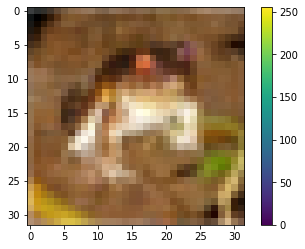

In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

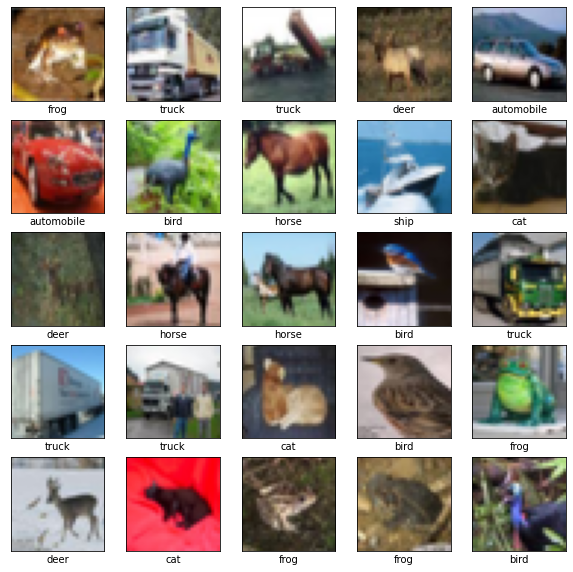

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Resize Images

The smallest MobileNet model takes images that are 96x96 but the CIFAR images are 32x32, so we'll resize them.

In [8]:
train_images.shape

(50000, 32, 32, 3)

In [9]:
train_images_96_x_96 = tf.image.resize(
    train_images, 
    (96,96),
    antialias=True
)

train_images_96_x_96 = train_images_96_x_96.numpy()

test_images_96_x_96 = tf.image.resize(
    test_images, 
    (96,96),
    antialias=True
)

test_images_96_x_96 = test_images_96_x_96.numpy()

In [12]:
train_images_96_x_96.shape

(50000, 96, 96, 3)

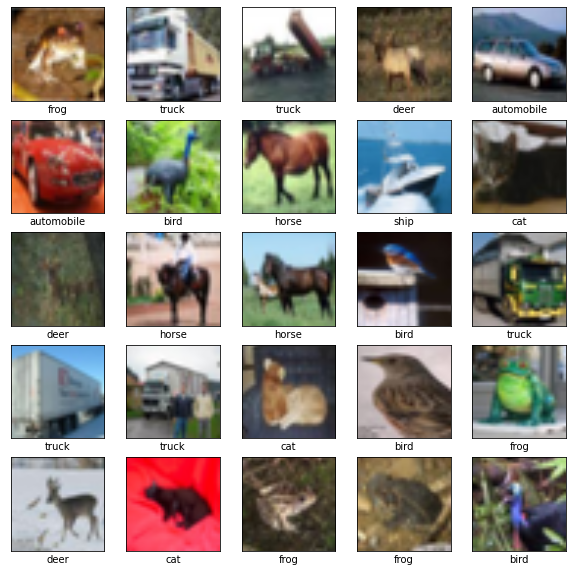

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_96_x_96[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Model

In [14]:
TF_HUB_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/4"
    # Use version /2 of the model for 1.13 compatibility

def make_model(base_model_trainable=False):
    model = tf.keras.Sequential([
        hub.KerasLayer(TF_HUB_URL, input_shape=(96,96,3), trainable=base_model_trainable),
        tf.keras.layers.Dense(10)
    ])
    return model

In [15]:
# Set base_model_trainable=False to for 1.13 compatibility

model = make_model(base_model_trainable=True)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 10)                10020     
Total params: 3,550,285
Trainable params: 3,516,173
Non-trainable params: 34,112
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.fit(train_images_96_x_96, train_labels, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 630s 403ms/step - loss: 0.8132 - accuracy: 0.7898
Epoch 2/5
1563/1563 [==============================] - 647s 414ms/step - loss: 0.5689 - accuracy: 0.8531
Epoch 3/5
1563/1563 [==============================] - 662s 424ms/step - loss: 0.5247 - accuracy: 0.8705
Epoch 4/5
1563/1563 [==============================] - 662s 424ms/step - loss: 0.4934 - accuracy: 0.8828
Epoch 5/5
1563/1563 [==============================] - 652s 417ms/step - loss: 0.4646 - accuracy: 0.8953


In [19]:
test_loss, test_acc = model.evaluate(test_images_96_x_96,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 15s - loss: 0.5977 - accuracy: 0.8569

Test accuracy: 0.8568999767303467


In [20]:
probability_model = tf.keras.Sequential([
    model, 
    tf.keras.layers.Softmax()
])

In [21]:
predictions = probability_model.predict(test_images_96_x_96)

In [22]:
predictions[0]

array([1.25801167e-03, 2.40049721e-03, 4.35599964e-03, 8.62876713e-01,
       2.72592111e-03, 8.96353275e-02, 2.43695155e-02, 2.75785220e-04,
       1.03011755e-02, 1.80090638e-03], dtype=float32)

In [23]:
np.argmax(predictions[0])

3

In [24]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    true_label = true_label[0]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
        100*np.max(predictions_array),
        class_names[true_label]),
        color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    true_label = true_label[0]
    
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

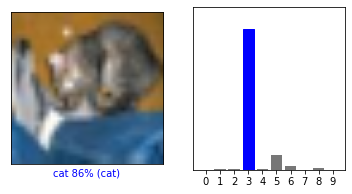

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images_96_x_96)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

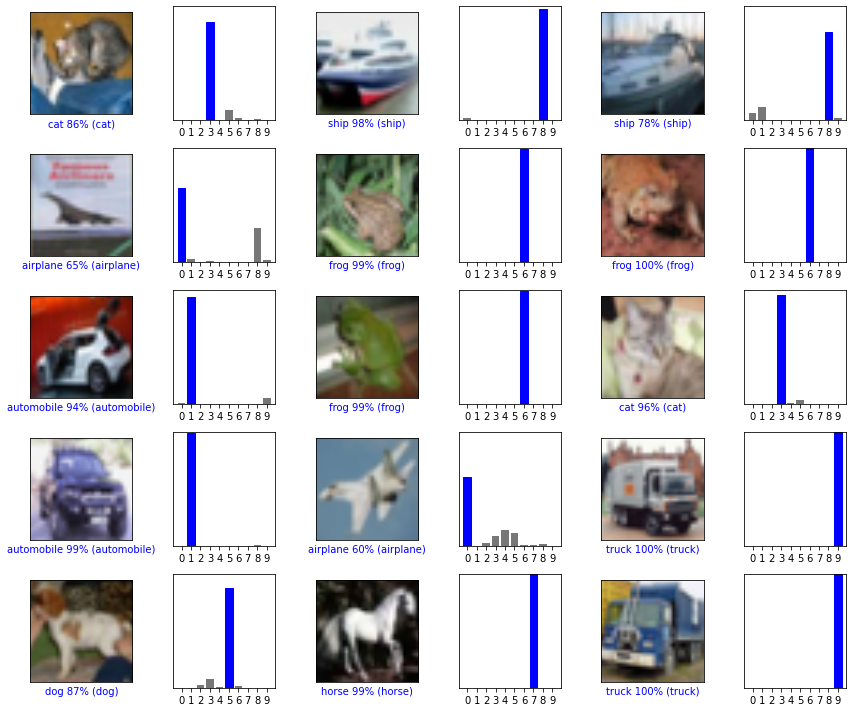

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images_96_x_96)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Export with model.save

In [27]:
# Read below for why we must disable this option before saving the model

tf.config.optimizer.set_experimental_options({
    'remapping': False
})

In [28]:
PATH =  'tmp/keras-cifar10-mobilenet-save-model'
! rm -r 'tmp/keras-cifar10-mobilenet-save-model'

In [29]:
model.save(PATH, save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: tmp/keras-cifar10-mobilenet-save-model/assets


INFO:tensorflow:Assets written to: tmp/keras-cifar10-mobilenet-save-model/assets


### Results

In [30]:
! saved_model_cli show --all --dir tmp/keras-cifar10-mobilenet-save-model/


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 96, 96, 3)
        name: serving_default_keras_layer_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function N

### Tensor/IO

Note in the corresponding model.json that the name and shape of the inputs and outputs matches the values you see in the signature definition. Take special care to note that the name is taken from the layer's name and not from the key in the inputs or outputs dictionary:

```
inputs['keras_layer_input'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 96, 96, 3)
    name: serving_default_keras_layer_input:0
outputs['dense'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 10)
    name: StatefulPartitionedCall:0
```

In this case we are also explicitly dealing with image data types so in the model.json we must also set the type of the input to image and specify its format and any normalization. Tensor/IO will preprocess the image to match this description before sending it into the model.

In [31]:
! cat model.json

{
	"name": "Keras CIFAR-10 MobileNet Save Model Example",
	"details": "Keras MobileNetV2 Model for CIFAR-10 dataset exported for prediction using the keras model.save api",
	"id": "keras-cifar10-mobilenet-save-model",
	"version": "1",
	"author": "doc.ai",
	"license": "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0",
	"model": {
		"file": "predict",
		"quantized": false,
		"type": "cifar10.basic",
		"backend": "tensorflow",
		"modes": ["predict"]
	},
	"inputs": [
		{
			"name": "serving_default_keras_layer_input",
			"type": "image",
			"shape": [-1,96,96,3],
			"format": "RGB",
			"normalize": {
				"standard": "[0,1]"
			}
		}
	],
	"outputs": [
		{
			"name": "StatefulPartitionedCall",
			"type": "array",
			"shape": [-1,10]
		}
	]
}

The initial execution of this model fails on device because of a missing kernel: `FusedBatchNorm`. This kernel is contained in *fused_batch_norm_op.cc*, which has been whitelisted, but it is still not compiling into the on device build.

FusedBatchNorm is an optimized operation that combines other ops and is controlled by the remapper option in grappler when exporting the model, see: https://www.tensorflow.org/guide/graph_optimization, remapper optimizer.

Disable the remapper optimization in grappler with the following code before saving the model:

```
tf.config.optimizer.set_experimental_options({
    'remapping': False
})
```

Once the remapper optimization has been disabled, I am able to run the model on device as expected.